# Risk Contributions and Risk Parity

> The word 'risk' derives from the early Italian risicare, which means 'to dare'. In this sense, risk is a choice rather than a fate. The actions we dare to take, which depend on how free we are to make choices, are what the story of risk is all about.

_Peter L. Bernstein, Against the Gods: The Remarkable Story of Risk_

In [1]:
import numpy as np
import pandas as pd

import edhec_risk_kit_206 as erk

%load_ext autoreload
%autoreload 2
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["1974":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["1974":]

rets = ind_rets["2013":][inds]
cov = rets.cov()

In [2]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = erk.portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

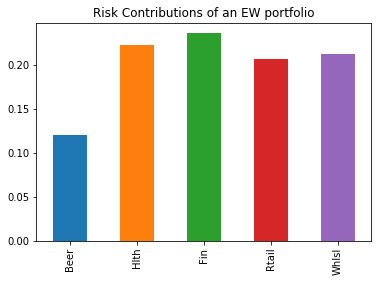

In [3]:
risk_contribution(erk.weight_ew(rets), cov).plot.bar(title="Risk Contributions of an EW portfolio");

In [4]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)


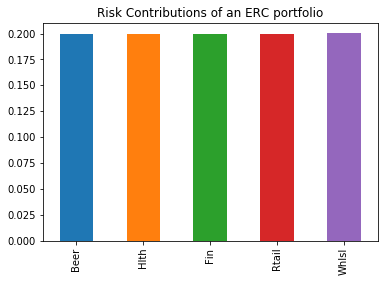

In [5]:
risk_contribution(equal_risk_contributions(cov), cov).plot.bar(title="Risk Contributions of an ERC portfolio");

In [6]:
def weight_erc(r, cov_estimator=erk.sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117007,0.149311,-0.702445,5.458192,0.066685,0.096232,0.566996,-0.518076


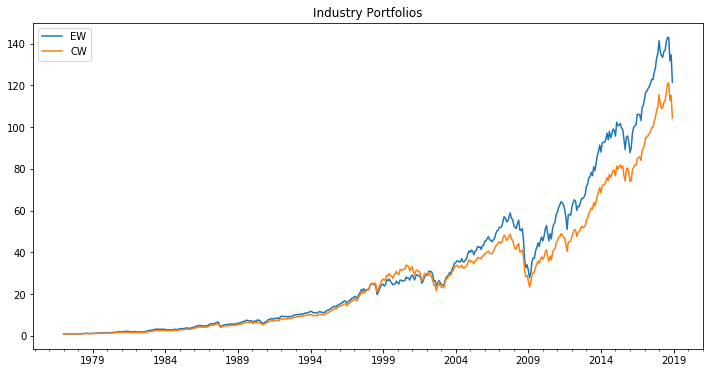

In [7]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Now, let's run a backtest of this new weighting scheme we've just developed. Be warned that this will likely take quite some time to run - depending on your computer's CPU horsepower, but on my laptop it took several minutes.

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117007,0.149311,-0.702445,5.458192,0.066685,0.096232,0.566996,-0.518076
ERC-Sample,0.120185,0.149185,-0.872577,7.019237,0.066886,0.096357,0.588203,-0.502950


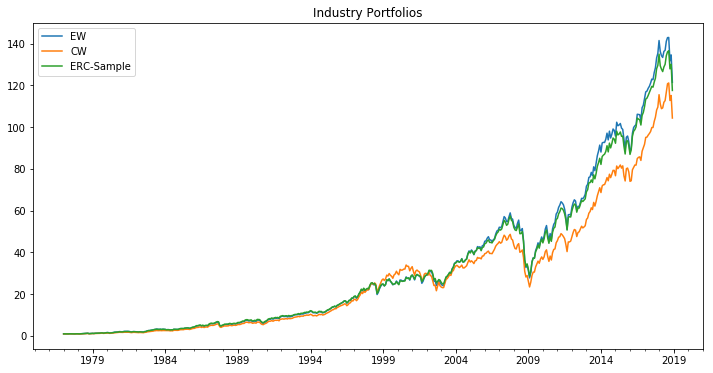

In [8]:
mv_erc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_erc, cov_estimator=erk.sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "ERC-Sample": mv_erc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

**Load the 49 Value Weighted industry portfolio returns. Limit the analysis to returns of the 49 VW portfolios from the most recent 5 years for which you have data i.e 2014-2018 both years inclusive. Also load the Market Caps of each of the 49 industries. Assume that the cap-weights as of the first month (2014-01) are the cap-weights we’ll use for this analysis.**

- Which Industry had the highest risk contribution in the cap-weighted portfolio?

In [44]:
import numpy as np
import pandas as pd
import edhec_risk_kit_206 as erk

ind_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["2014":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["2014":]
cov = ind_rets.cov()
ind_rets.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
2014-01,-0.0801,-0.0346,-0.0759,-0.0054,-0.0833,-0.0856,0.0078,-0.0644,-0.0620,-0.0758,...,-0.0358,-0.0199,-0.0235,-0.0759,-0.0477,-0.0350,-0.0530,-0.0235,-0.0556,-0.0662
2014-02,0.0300,0.0495,0.0192,0.0162,0.0335,0.0339,0.0919,0.0825,0.0345,0.0553,...,0.0788,0.0211,0.0450,0.0579,0.0484,0.0301,0.0381,0.0473,0.0301,0.0266
2014-03,0.0373,0.0319,0.0165,0.0478,0.0407,0.0448,-0.0706,-0.0010,0.0175,-0.0040,...,-0.0124,0.0268,0.0041,-0.0121,0.0173,0.0298,0.0217,-0.0263,0.0099,0.0561
2014-04,-0.0260,0.0008,0.0470,0.0156,0.0569,-0.0113,-0.0455,-0.0187,0.0296,-0.0382,...,-0.0149,0.0111,-0.0054,-0.0084,-0.0123,-0.0465,-0.0153,-0.0307,-0.0240,0.0314
2014-05,0.0986,0.0510,0.0062,0.0319,0.0399,-0.0107,0.0354,-0.0046,-0.0050,0.0222,...,0.0406,0.0545,0.0344,0.0022,0.0240,0.0175,0.0301,0.0352,-0.0020,-0.0039


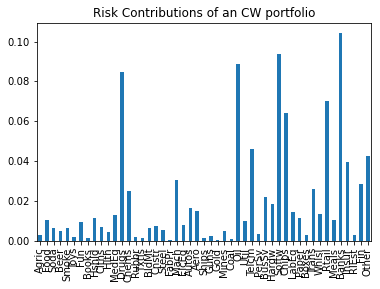

In [46]:
riskCont = erk.risk_contribution(erk.weight_cw(ind_rets, cap_weights=ind_mcap), cov)
riskCont.plot.bar(title="Risk Contributions of an CW portfolio");

**What was the highest risk contribution from any one industry in the cap-weighted portfolio?**

In [47]:
riskCont.sort_values(ascending=False)

Banks    0.104060
Softw    0.093745
Oil      0.088914
Drugs    0.084653
Rtail    0.070120
Chips    0.063869
Telcm    0.046113
Other    0.042484
Insur    0.039418
Mach     0.030455
Fin      0.028291
Trans    0.026039
Chems    0.025071
BusSv    0.021816
Hardw    0.018487
Autos    0.016170
Aero     0.014904
LabEq    0.014527
Whlsl    0.013434
MedEq    0.012792
Hshld    0.011568
Paper    0.011139
Meals    0.010572
Food     0.010084
Util     0.009626
Fun      0.009335
ElcEq    0.007693
Cnstr    0.007428
Clths    0.006676
Smoke    0.006470
Soda     0.006309
BldMt    0.006061
Steel    0.005182
Mines    0.004954
Beer     0.004776
Hlth     0.004203
PerSv    0.003219
Agric    0.002886
RlEst    0.002803
Boxes    0.002595
Guns     0.002263
Rubbr    0.001972
Toys     0.001796
Ships    0.001276
Txtls    0.001276
Books    0.001203
Coal     0.000870
FabPr    0.000309
Gold     0.000096
dtype: float64

**Which Industry had the highest risk contribution in the equal-weighted portfolio?**

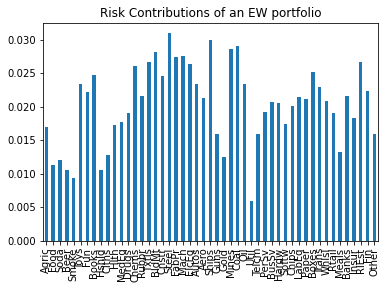

In [49]:
erk.risk_contribution(erk.weight_ew(ind_rets), cov).plot.bar(title="Risk Contributions of an EW portfolio");

In [50]:
ewRiskCont = erk.risk_contribution(erk.weight_ew(ind_rets), cov)
ewRiskCont.sort_values(ascending=False)

Steel    0.030938
Ships    0.030005
Coal     0.029025
Mines    0.028641
BldMt    0.028106
Mach     0.027558
FabPr    0.027473
RlEst    0.026693
Txtls    0.026679
ElcEq    0.026376
Chems    0.026042
Boxes    0.025176
Books    0.024772
Cnstr    0.024585
Oil      0.023372
Toys     0.023371
Autos    0.023338
Trans    0.022935
Fin      0.022416
Fun      0.022200
Banks    0.021622
Rubbr    0.021541
LabEq    0.021497
Aero     0.021306
Paper    0.021104
Whlsl    0.020881
BusSv    0.020757
Hardw    0.020570
Chips    0.020140
PerSv    0.019258
Drugs    0.019058
Rtail    0.019039
Insur    0.018249
MedEq    0.017747
Softw    0.017357
Hlth     0.017251
Agric    0.016982
Guns     0.015950
Other    0.015948
Telcm    0.015910
Meals    0.013261
Clths    0.012855
Gold     0.012449
Soda     0.012041
Food     0.011227
Beer     0.010500
Hshld    0.010492
Smoke    0.009393
Util     0.005916
dtype: float64

**Using the Sample Covariance over the 5 year period, compute the weights of the ERC portfolio. What sector portfolio is assigned the highest weight in the ERC portfolio?**

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.048561,0.116542,-1.798291,5.857104,0.062586,0.088072,0.154861,-0.150361
CW,0.076372,0.115946,-1.591494,5.359304,0.058895,0.081560,0.389123,-0.138680
ERC-Sample,0.048161,0.109527,-1.795021,6.021856,0.058521,0.079727,0.161239,-0.139152


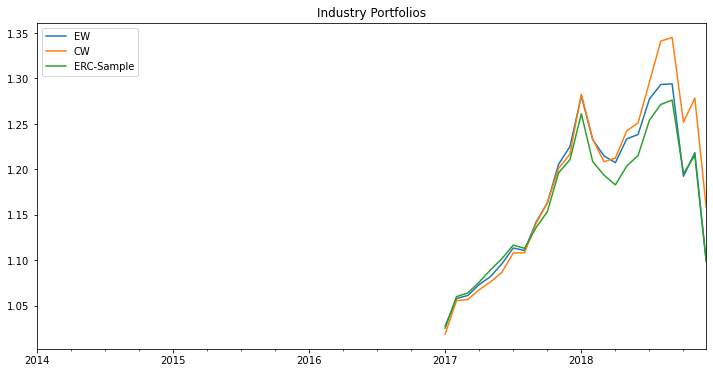

In [51]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
mv_erc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_erc, cov_estimator=erk.sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "ERC-Sample": mv_erc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

In [68]:
ind_rets.columns[(erk.weight_erc(ind_rets, cov_estimator=erk.sample_cov) ==erk.weight_erc(ind_rets, cov_estimator=erk.sample_cov).max())]

Index(['Util'], dtype='object')

In [70]:
erk.weight_erc(ind_rets).max()

0.05215573493038538

**What is the weight of the sector portfolio that is assigned the lowest weight in the ERC portfolio?**

In [71]:
ind_rets.columns[(erk.weight_erc(ind_rets, cov_estimator=erk.sample_cov) ==erk.weight_erc(ind_rets, cov_estimator=erk.sample_cov).min())]

Index(['Steel'], dtype='object')

In [73]:
erk.weight_erc(ind_rets).min()

0.012809105062715143

**In the cap-weighted portfolio what is the difference in risk contributions between the largest contributor to portfolio risk and the smallest contributor to portfolio risk?**

In [53]:
riskCont.max() - riskCont.min()

0.1039644943981684

**In the equal-weighted portfolio what is the difference in risk contributions between the largest contributor to portfolio risk and the smallest contributor to portfolio risk?**

In [54]:
ewRiskCont.max() - ewRiskCont.min()

0.025021757624911465